<a href="https://colab.research.google.com/github/gkpatwardhan/CS445_RayTracer/blob/basic_solid_sphere/RayTracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm      # for showing progress bar when rendering images
!pip install VectorsPY # for vector 3

In [ ]:
# imports
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from VectorsPY import Vector3 as Vector3Base
from collections.abc import Callable
import functools

In [ ]:
# Settings types

class Vector3(Vector3Base):
  def __truediv__(self, number: any) -> 'Vector3':
    return Vector3(self.x / number, self.y / number, self.z / number)

  def __mul__(self, number: any) -> 'Vector3':
    return Vector3(self.x * number, self.y * number, self.z * number)

  def __add__(self, vec: 'Vector3'):
    return Vector3(self.x + vec.x, self.y + vec.y, self.z + vec.z)

  def __sub__(self, vec: 'Vector3'):
    return Vector3(self.x - vec.x, self.y - vec.y, self.z - vec.z)

  def unit_vector(self) -> 'Vector3':
    return self / self.magnitude()

  def dot(self, other_vec: 'Vector3') -> float:
    return (self.x * other_vec.x) + (self.y * other_vec.y) + (self.z * other_vec.z)

# create two aliases for vector 3 -- one for point and another for color
Point = Vector3
Color = Vector3

In [ ]:
# Color helper functions
def write_color(pixel_color: Color) -> str:
    return f"{int(255.999 * (pixel_color.x))} {int(255.999 * (pixel_color.y))} {int(255.999 * (pixel_color.z))}\n"

In [ ]:
# Create PPM helper function
def create_ppm(ppm_file: str, image_width, image_height, pixel_color: Callable[[int, int], Color]) -> None:
    ppm_image = open(ppm_file, 'w')
    height = width = 256
    ppm_image.write(f"P3\n{image_width} {image_height}\n255\n")
    for h in tqdm(range(image_height)):
        for w in range(image_width):
            ppm_image.write(write_color(pixel_color(h, w)))
    ppm_image.close()

    img = cv2.imread(ppm_file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

100%|██████████| 256/256 [00:00<00:00, 2220.81it/s]


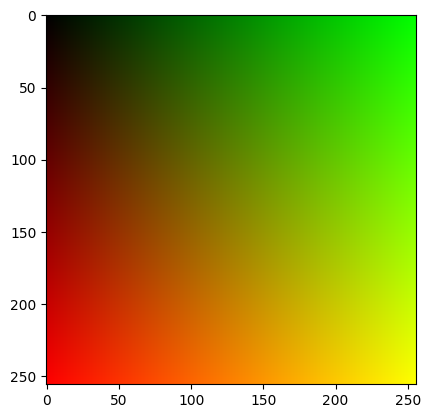

In [ ]:
# Hello World PPM - ensure this functions correctly as future code will use similar logic to create, store and view PPM images
def hello_world_ppm():
    ppm_file = 'hello_world.ppm'
    height = width = 256
    create_ppm(ppm_file, width, height, lambda h, w: Color(float(h) / (width - 1), float(w) / (height - 1), 0))
hello_world_ppm()

In [ ]:
# Ray class
class Ray:
    def __init__(self, origin: Point, direction: Vector3):
        self.origin = origin
        self.direction = direction

    def at(self, time: float) -> Point:
        return self.origin + (time * self.direction)

In [ ]:
# Raycast image dimensions
aspect_ratio = 16.0 / 9.0
image_width = 400
image_height = max(1, int(image_width / aspect_ratio))

viewport_height = 2.0
viewport_width = viewport_height * float(image_width) / float(image_height)

# Camera properties
focal_length = 1.0
camera_center = Point(0, 0, 0)

viewport_u = Vector3(viewport_width, 0, 0)
viewport_v = Vector3(0, -viewport_height, 0)

pixel_delta_u = viewport_u / image_width
pixel_delta_v = viewport_v / image_height

viewport_upper_left = camera_center - Vector3(0, 0, focal_length) - (viewport_u / 2) - (viewport_v / 2)

100%|██████████| 225/225 [00:00<00:00, 263.02it/s]


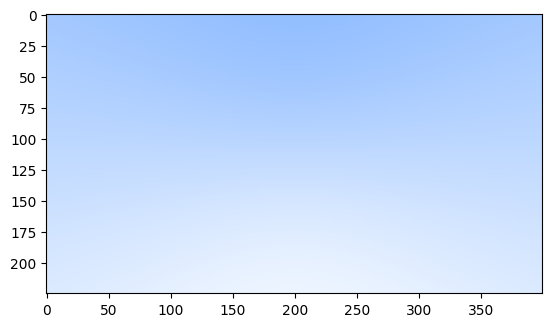

In [ ]:
# Skyline PPM -- basic test to ensure Vector, Ray, and aspect ratio math works correctly
pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5
ppm_file = 'skyline.ppm'
def ray_color(ray: Ray) -> Color:
    unit_direction = ray.direction.unit_vector()
    a = (unit_direction.y + 1.0) * 0.5
    return Color(1.0, 1.0, 1.0)*(1.0-a) + Color(0.5, 0.7, 1.0)*a
def skyline_pixel_color(image_height: int, image_width: int, h: int, w: int) -> Color:
    pixel_center = pixel00_loc + (pixel_delta_u * w) + (pixel_delta_v * h)
    ray_direction = pixel_center - camera_center
    return ray_color(Ray(camera_center, ray_direction))
create_ppm(ppm_file, image_width, image_height, functools.partial(skyline_pixel_color, image_height, image_width))

In [ ]:
class Sphere:
    def __init__(self, center: Point, radius: float):
        self.center = center
        self.radius = radius

    def hit_sphere(self, ray: Ray) -> bool:
        oc = ray.origin - self.center
        a = ray.direction.dot(ray.direction)
        b = oc.dot(ray.direction) * 2.0
        c = oc.dot(oc) - (self.radius ** 2)
        return ((b*b) - (4*a*c)) >= 0

100%|██████████| 225/225 [00:01<00:00, 191.02it/s]


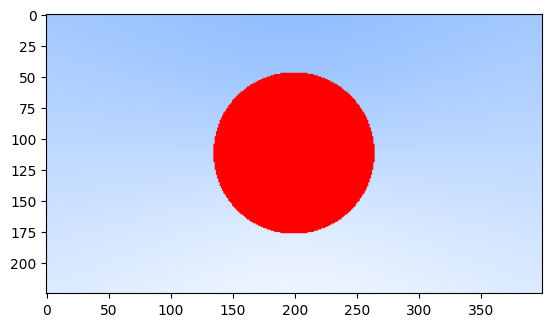

In [ ]:
# Raycast sphere (without lighing) -- basic test of sphere ray intersection logic
pixel00_loc = viewport_upper_left + (pixel_delta_u + pixel_delta_v)*0.5
ppm_file = 'solid_sphere.ppm'
def ray_color(sphere: Sphere, ray: Ray) -> Color:
    if (sphere.hit_sphere(ray)):
        return Color(1, 0, 0)
    unit_direction = ray.direction.unit_vector()
    a = (unit_direction.y + 1.0) * 0.5
    return Color(1.0, 1.0, 1.0)*(1.0-a) + Color(0.5, 0.7, 1.0)*a
def solid_sphere_pixel_color(image_height: int, image_width: int, sphere: Sphere, h: int, w: int) -> Color:
    pixel_center = pixel00_loc + (pixel_delta_u * w) + (pixel_delta_v * h)
    ray_direction = pixel_center - camera_center
    return ray_color(sphere, Ray(camera_center, ray_direction))
create_ppm(ppm_file, image_width, image_height, functools.partial(solid_sphere_pixel_color, image_height, image_width, Sphere(Point(0, 0, -1), 0.5)))